# LSTM model zonder mempool data

In [1]:
# Import data
import pandas as pd


df = pd.read_csv('C:/Users/boris/Documents/M&T/Financial Innovation/Afstuderen/Scriptie/Feature_engineering/df_geen_mempool.csv')


In [2]:
df= df.drop(columns = 'regime_change')

In [3]:
df

,Timestamp,Open,High,Low,Close,Volume,value,value_classification,daily_std,MA7,MA30,market_regime
0,2018-02-01,9974.91,10187.56,8820.96,8970.00,20517.085284,30.0,Fear,683.300,10602.648571,12637.540000,1
1,2018-02-02,8970.00,9234.10,7625.25,8580.00,47828.982222,15.0,Extreme Fear,804.425,10250.204286,12429.063333,1
2,2018-02-03,8551.19,9443.96,8170.71,9386.72,17968.929040,40.0,Fear,636.625,9956.165714,12249.274000,1
3,2018-02-04,9391.30,9491.20,8189.32,8301.65,14407.720751,24.0,Extreme Fear,650.940,9484.974286,11980.415000,1
4,2018-02-05,8301.65,8416.03,6865.66,6877.61,37314.242065,11.0,Extreme Fear,775.185,8862.992857,11650.574333,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2660,2025-05-15,103514.00,104184.00,101442.00,103793.00,1339.093301,70.0,Greed,1371.000,103740.571429,95361.833333,0
2661,2025-05-16,103800.00,104570.00,103137.00,103506.00,994.760377,71.0,Greed,716.500,103814.142857,96010.500000,0
2662,2025-05-17,103503.00,103720.00,102668.00,103153.00,459.809889,74.0,Greed,526.000,103577.571429,96617.133333,0
2663,2025-05-18,103172.00,106635.00,103149.00,106520.00,905.179396,74.0,Greed,1743.000,103919.142857,97352.200000,0


In [4]:
# Check for missing values in the 'value' column
print("Number of missing values in 'value' column:", df['value'].isna().sum())

# Interpolate missing values in the 'value' column using linear interpolation
df['value'] = df['value'].interpolate(method='linear')

# Verify that all missing values are filled
print("Number of missing values after interpolation:", df['value'].isna().sum())


Number of missing values in 'value' column: 4
Number of missing values after interpolation: 0


Om te zorgen dat exact dezelfde data als het model met mempooldata wordt gebruikt, zorg ik dat de datums in df: 
- First date in dataset: 2018-02-01
- Last date in dataset: 2025-05-10 

In [5]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filter data between start and end dates
start_date = '2018-02-01'
end_date = '2025-05-10'

df = df[(df['Timestamp'] >= start_date) & (df['Timestamp'] <= end_date)]

# Reset index after filtering
df = df.reset_index(drop=True)


In [6]:
# pip install tensorflow


In [7]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM


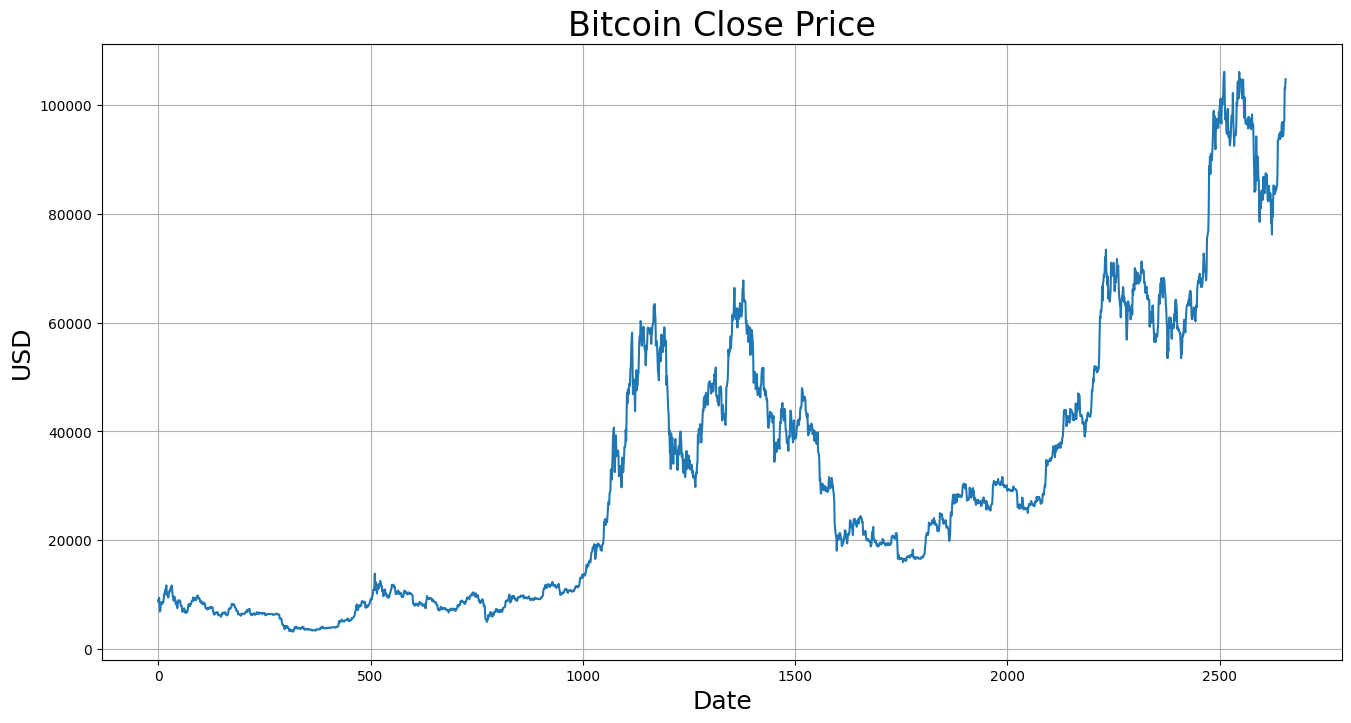

In [8]:
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.grid(True)
plt.show()


In [9]:
# Voeg features toe aan feature lijst
feature_columns = ['Close', 'Volume', 'value', 'daily_std', 'MA7', 'MA30', 'market_regime']

# Maak features en target sets
features = df[feature_columns].values  # numpy array van alle features
target = df[['Close']].values  # Doel is nog steeds de Close prijs

# Train-val-test splits 
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
test_size = len(df) - train_size - val_size

train_end = train_size
val_end = train_size + val_size

In [10]:
# Splits features en target in train, val, test
train_features = features[:train_end]
val_features = features[train_end:val_end]
test_features = features[val_end:]

train_target = target[:train_end]
val_target = target[train_end:val_end]
test_target = target[val_end:]

In [11]:
# Normaliseer ALLE features op basis van training set
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_features)
val_scaled = scaler.transform(val_features)
test_scaled = scaler.transform(test_features)

In [12]:
# Target schaal apart houden en fitten op train target
target_scaler = MinMaxScaler(feature_range=(0,1))
train_target_scaled = target_scaler.fit_transform(train_target)
val_target_scaled = target_scaler.transform(val_target)
test_target_scaled = target_scaler.transform(test_target)

In [13]:
# Sequenties maken 
def create_sequences(features, target, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i])  # alle features in sequentie
        y.append(target[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, train_target_scaled)
X_val, y_val = create_sequences(val_scaled, val_target_scaled)
X_test, y_test = create_sequences(test_scaled, test_target_scaled)

# Check shapes
print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)

X_train shape: (1799, 60, 7)
y_train shape: (1799, 1)


# Iteratie 1: (simpel model, even kijken of het werkt)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Zet de random seed voor reproduceerbaarheid
tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  
model.add(LSTM(25, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))  # Voorspelling van 1 waarde: Close prijs

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\boris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping om overfitting te voorkomen
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train het model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0150 - val_loss: 0.0035
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 9.2224e-04 - val_loss: 0.0014
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 8.6143e-04 - val_loss: 0.0013
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 8.1923e-04 - val_loss: 0.0013
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 7.8314e-04 - val_loss: 0.0014
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 7.4996e-04 - val_loss: 0.0014


In [17]:
# Make predictions on validation set
val_predictions = model.predict(X_val)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
print(f"Validation RMSE: {val_rmse}")

# Since the data was scaled, we should also show the unscaled RMSE
unscaled_val_rmse = val_rmse * (target_scaler.data_max_ - target_scaler.data_min_)
print(f"Unscaled Validation RMSE: {unscaled_val_rmse}")

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_val - val_predictions) / y_val)) * 100
print(f"Validation MAPE: {mape:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Validation RMSE: 0.03738715281681711
Unscaled Validation RMSE: [2415.9922112]
Validation MAPE: 6.20%


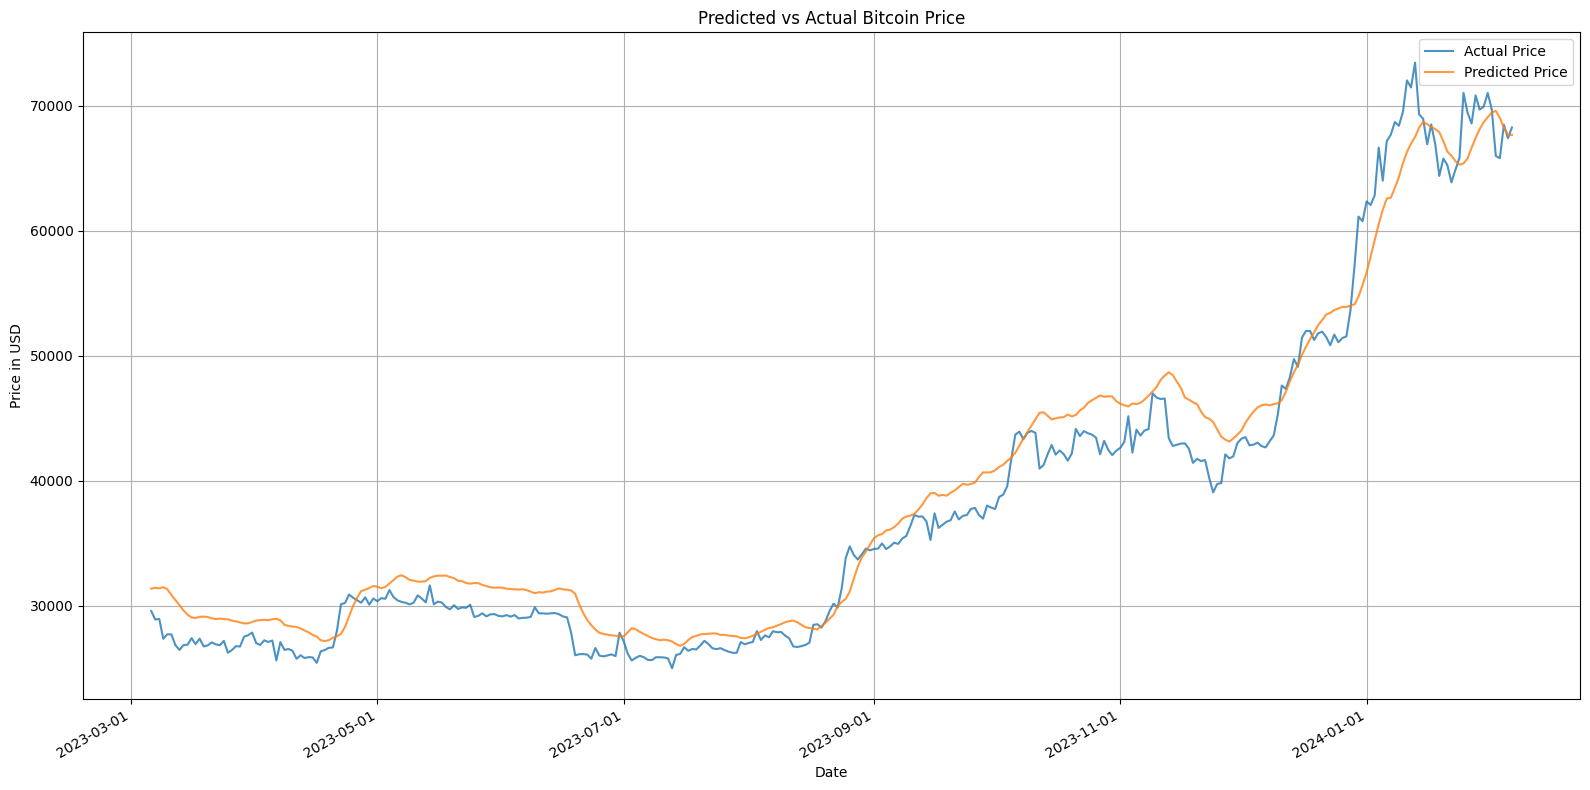

In [ ]:
# First define training size and sequence length
training_size = len(X_train)
sequence_length = X_train.shape[1]  # Get sequence length from training data shape

# Get the dates corresponding to validation set
val_dates = df['Timestamp'][training_size+sequence_length:training_size+len(y_val)+sequence_length]

# Show the unscaled version
unscaled_y_val = target_scaler.inverse_transform(y_val.reshape(-1, 1))
unscaled_predictions = target_scaler.inverse_transform(val_predictions)

plt.figure(figsize=(16, 8))
plt.plot(val_dates, unscaled_y_val, label='Actual Price', alpha=0.8)
plt.plot(val_dates, unscaled_predictions, label='Predicted Price', alpha=0.8)
plt.title('Predicted vs Actual Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)

# Format x-axis to show dates properly
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
from matplotlib.dates import DateFormatter
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


In [19]:
# Calculate MAPE on validation set
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Get unscaled actual and predicted values
actual_values = target_scaler.inverse_transform(y_val.reshape(-1, 1))
predicted_values = target_scaler.inverse_transform(val_predictions)

# Calculate MAPE
val_mape = mean_absolute_percentage_error(actual_values, predicted_values)

# Calculate RMSE
val_rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

print(f'Validation MAPE: {val_mape:.2f}%')
print(f'Validation RMSE: ${val_rmse:,.2f}')


Validation MAPE: 5.61%
Validation RMSE: $2,415.99


# Grid search

In [26]:
# import itertools
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.metrics import mean_squared_error

# # Define parametergrid
# param_grid = {
#     'units_per_layer': [[25,25], [50,50], [150,150], [25,50], [50,150]], #Units
#     'num_layers': [1, 2, 3],
#     'return_sequences': [[True], [True, False], [True, True, False]],  # afgestemd op num_layers
#     'dropout': [0.0, 0.2, 0.3],
#     'recurrent_dropout': [0.0, 0.2, 0.3],
#     'batch_size': [16, 32, 64],
#     'learning_rate': [0.01, 0.001, 0.0001],
#     'epochs': [100]
# }

# # Combinaties zonder return_sequences
# base_keys = ['units_per_layer', 'num_layers', 'dropout', 'recurrent_dropout', 'batch_size', 'learning_rate', 'epochs']
# base_values = [param_grid[k] for k in base_keys]
# base_combinations = list(itertools.product(*base_values))

# results = []

# for base in base_combinations:
#     base_config = dict(zip(base_keys, base))

#     # Selecteer juiste return_sequences patroon op basis van aantal lagen
#     if base_config['num_layers'] == 1:
#         return_seq_options = [[True]]
#     elif base_config['num_layers'] == 2:
#         return_seq_options = [[True, False]]
#     else:
#         return_seq_options = [[True, True, False]]

#     for rs in return_seq_options:
#         config = base_config.copy()
#         config['return_sequences'] = rs

#         tf.keras.backend.clear_session()
#         model = Sequential()

#         for i in range(config['num_layers']):
#             return_seq = config['return_sequences'][i]
#             units = base_config['units_per_layer'][i]

#             if i == 0:
#                 model.add(LSTM(
#                     units=units,
#                     return_sequences=return_seq,
#                     dropout=config['dropout'],
#                     recurrent_dropout=config['recurrent_dropout'],
#                     input_shape=(X_train.shape[1], X_train.shape[2])
#                 ))
#             else:
#                 model.add(LSTM(
#                     units=units,
#                     return_sequences=return_seq,
#                     dropout=config['dropout'],
#                     recurrent_dropout=config['recurrent_dropout']
#                 ))

#         model.add(Dense(25))
#         model.add(Dense(1))

#         model.compile(optimizer=Adam(learning_rate=config['learning_rate']), loss='mean_squared_error')

#         early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#         history = model.fit(
#             X_train, y_train,
#             validation_data=(X_val, y_val),
#             epochs=config['epochs'],
#             batch_size=config['batch_size'],
#             callbacks=[early_stop],
#             verbose=0
#         )

#         val_pred = model.predict(X_val, verbose=0)
#         rmse = np.sqrt(mean_squared_error(y_val, val_pred))

#         results.append({
#             **config,
#             'val_rmse': rmse
#         })

# # Beste config selecteren
# best_config = min(results, key=lambda x: x['val_rmse'])

# # Print resultaten
# print("\nBeste hyperparameters gevonden na grid search:")
# print("------------------------------------------------")
# print(f"Number of units (per layer): {best_config['units_per_layer']}")  
# print(f"Number of layers: {best_config['num_layers']}")
# print(f"Return sequences: {best_config['return_sequences']}")
# print(f"Dropout: {best_config['dropout']}")
# print(f"Recurrent Dropout: {best_config['recurrent_dropout']}")
# print(f"Batch size: {best_config['batch_size']}")
# print(f"Learning rate: {best_config['learning_rate']}")
# print(f"Number of epochs: {best_config['epochs']} (early stopping was actief)")

# Model met beste hyperparameters (uit grid search)

Epoch 1/100


c:\Users\boris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0692 - val_loss: 0.0054
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0

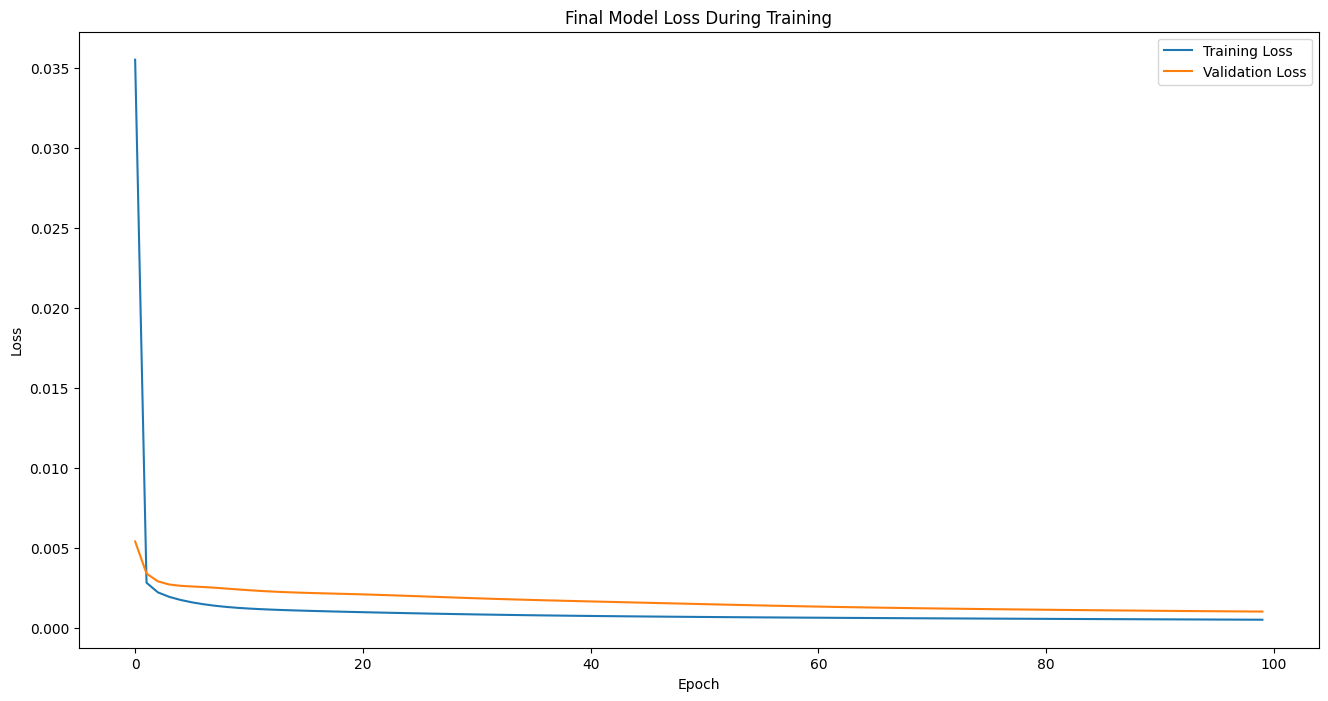

In [21]:
# Create final model with specified architecture
tf.random.set_seed(42)  # Set seed for reproducibility

final_model = Sequential()
final_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(LSTM(150, return_sequences=False))
final_model.add(Dense(25))
final_model.add(Dense(1))

# Compile model with lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
final_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model for 100 epochs
history = final_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [22]:
# Calculate validation RMSE and MAPE for final model
val_predictions = final_model.predict(X_val)

# Unscale predictions and actual values
unscaled_y_val = target_scaler.inverse_transform(y_val.reshape(-1, 1))
unscaled_predictions = target_scaler.inverse_transform(val_predictions)

# Calculate RMSE
val_rmse = np.sqrt(mean_squared_error(unscaled_y_val, unscaled_predictions))

# Calculate MAPE
val_mape = np.mean(np.abs((unscaled_y_val - unscaled_predictions) / unscaled_y_val)) * 100

print(f"Validation RMSE: ${val_rmse:,.2f}")
print(f"Validation MAPE: {val_mape:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Validation RMSE: $2,079.20
Validation MAPE: 3.89%


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


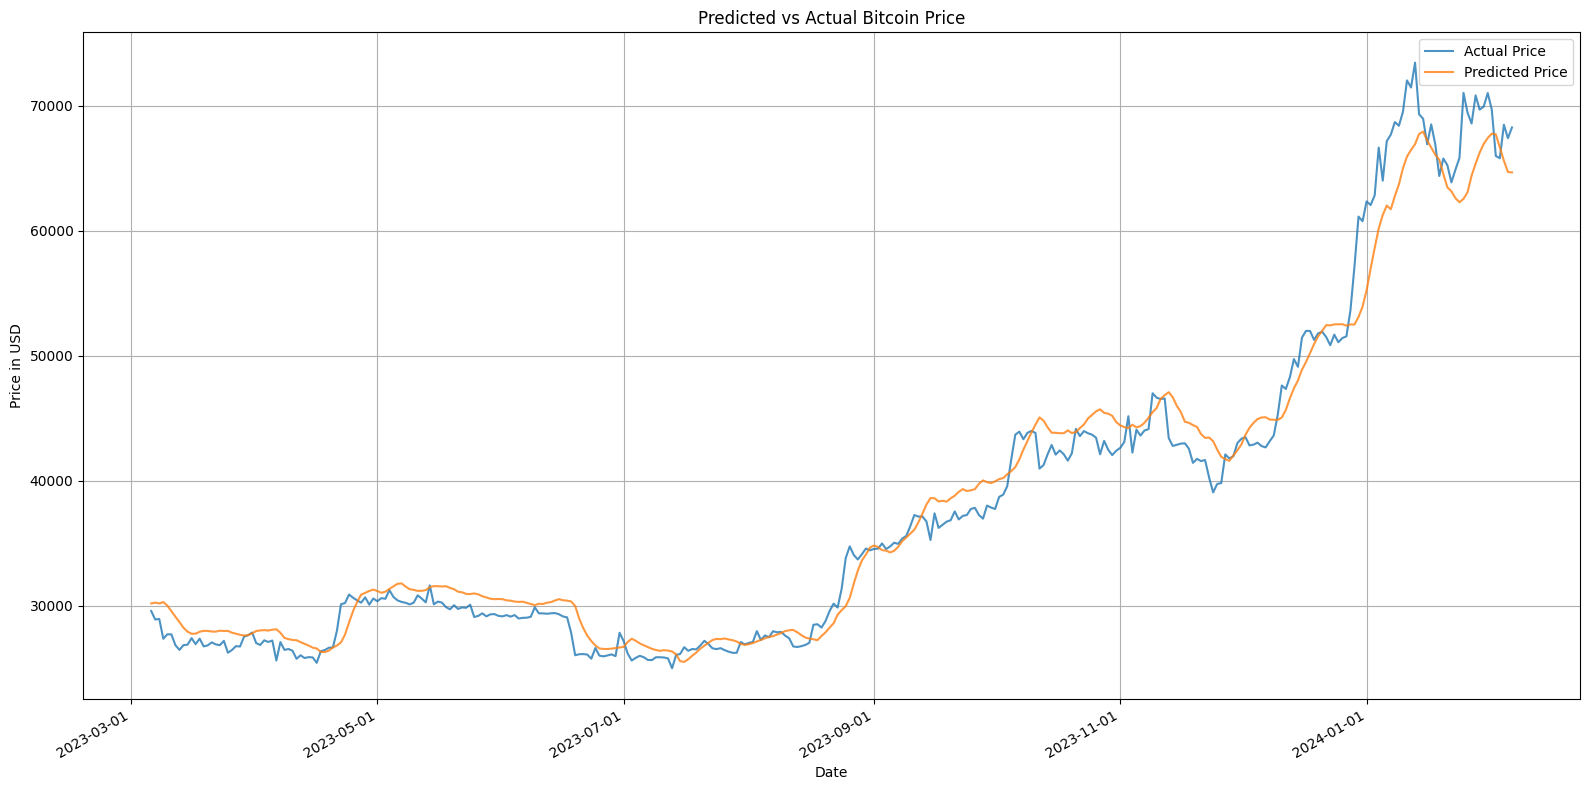

In [23]:
# Make predictions on validation set
val_predictions = final_model.predict(X_val)

# For better date visualization, we can use the actual dates
# First define training size and sequence length 
training_size = len(X_train)
sequence_length = X_train.shape[1]  # Get sequence length from training data shape

# Get the dates corresponding to validation set
val_dates = df['Timestamp'][training_size+sequence_length:training_size+len(y_val)+sequence_length]

# Show the unscaled version
unscaled_y_val = target_scaler.inverse_transform(y_val.reshape(-1, 1))
unscaled_predictions = target_scaler.inverse_transform(val_predictions)

plt.figure(figsize=(16, 8))
plt.plot(val_dates, unscaled_y_val, label='Actual Price', alpha=0.8)
plt.plot(val_dates, unscaled_predictions, label='Predicted Price', alpha=0.8)
plt.title('Predicted vs Actual Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)

# Format x-axis to show dates properly
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
from matplotlib.dates import DateFormatter
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


In [39]:
unscaled_predictions = unscaled_predictions[:len(val_dates)]



In [40]:
# # Zet validatieresultaten in een dataframe
# val_results_df = pd.DataFrame({
#     'Date': val_dates,
#     'Actual_Price': unscaled_y_val.flatten(),
#     'Predicted_Price': unscaled_predictions.flatten()
# })

# # (Optioneel) bereken RMSE en MAPE voor validatieset
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# import numpy as np

# val_rmse = np.sqrt(mean_squared_error(unscaled_y_val, unscaled_predictions))
# val_mape = mean_absolute_percentage_error(unscaled_y_val, unscaled_predictions) * 100

# # Geef de bestandsnaam mee met evaluatiemetrics
# val_filename = f'lstm_val_results_rmse_{val_rmse:.2f}_mape_{val_mape:.2f}.csv'

# # Sla op
# val_results_df.to_csv(val_filename, index=False)
# print(f"Validation results saved to {val_filename}")


Validation results saved to lstm_val_results_rmse_35171.50_mape_100.46.csv


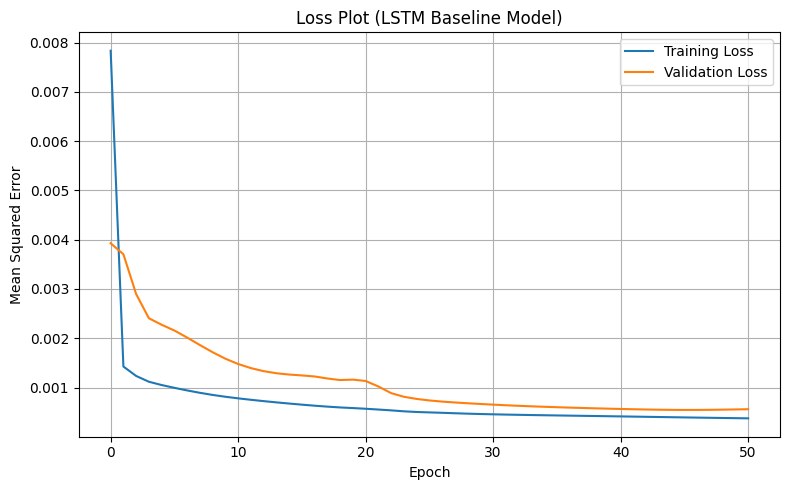

In [1]:
# from IPython.display import Image, display

# # Laad en toon de afbeelding
# image_path = r"C:\Users\boris\Downloads\lossplot_baseline.png"
# display(Image(filename=image_path))


# Plots maken van optimalisatie

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


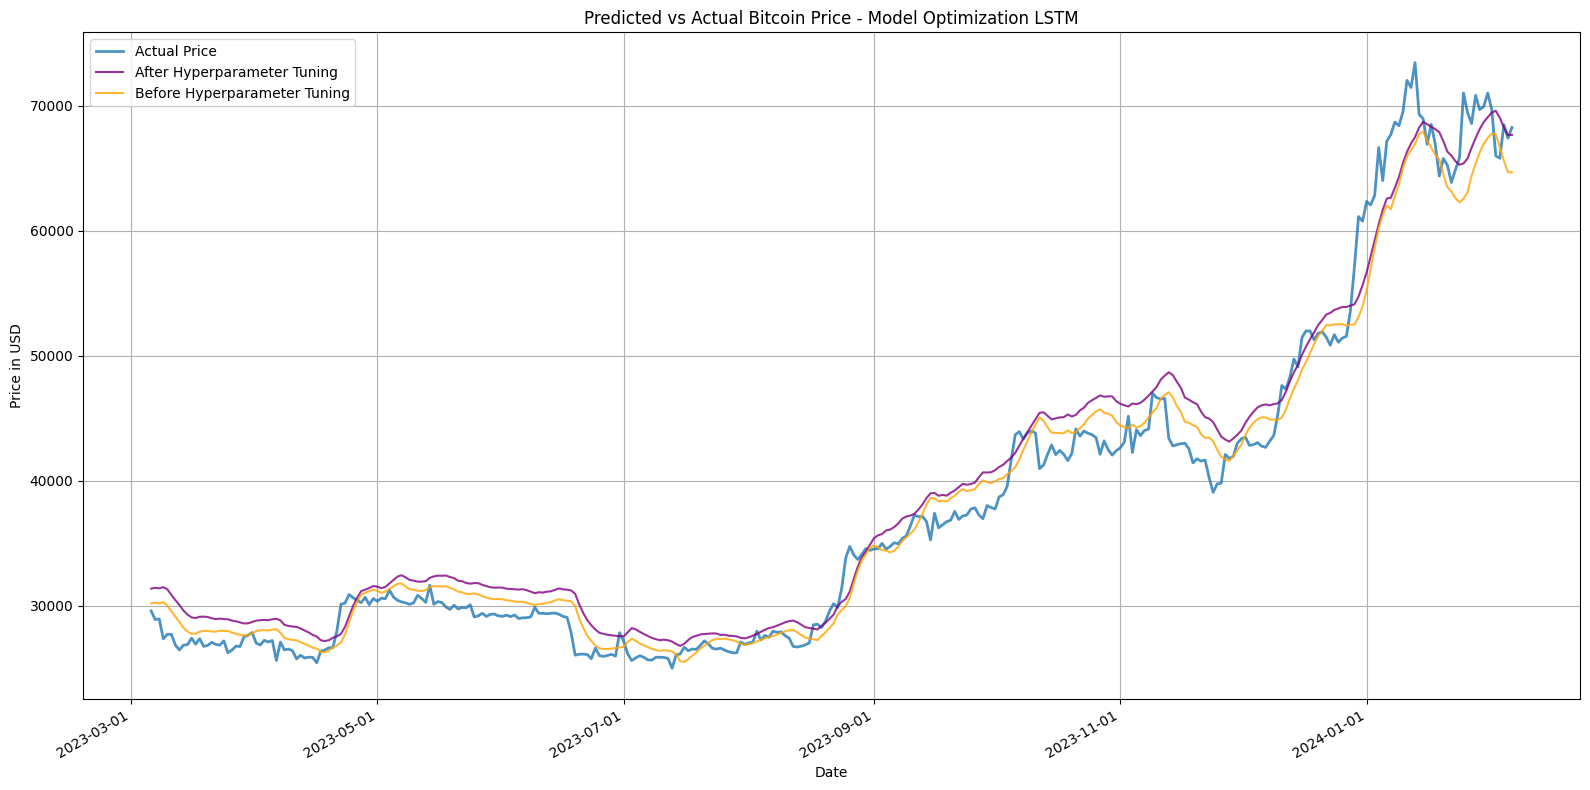

In [24]:
# Get predictions from both models
val_predictions_model = model.predict(X_val)
val_predictions_final = final_model.predict(X_val)

# Get validation dates
val_dates = df['Timestamp'][training_size+sequence_length:training_size+len(y_val)+sequence_length]

# Unscale predictions and actual values
unscaled_y_val = target_scaler.inverse_transform(y_val.reshape(-1, 1))
unscaled_predictions_model = target_scaler.inverse_transform(val_predictions_model)
unscaled_predictions_final = target_scaler.inverse_transform(val_predictions_final)

# Create comparison plot
plt.figure(figsize=(16, 8))
plt.plot(val_dates, unscaled_y_val, label='Actual Price', linewidth=2, alpha=0.8)
plt.plot(val_dates, unscaled_predictions_model, label='After Hyperparameter Tuning', color='purple', alpha=0.8)
plt.plot(val_dates, unscaled_predictions_final, label='Before Hyperparameter Tuning', color='orange', alpha=0.8)
plt.title('Predicted vs Actual Bitcoin Price - Model Optimization LSTM')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)

# Format x-axis dates
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


# Beste baseline model testen op test set

In [25]:
# Get predictions from model on test set
test_predictions = model.predict(X_test)

# Unscale predictions and actual values
unscaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
unscaled_test_predictions = target_scaler.inverse_transform(test_predictions)

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(unscaled_y_test, unscaled_test_predictions))

# Calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = mape(unscaled_y_test, unscaled_test_predictions)

print("\nModel after Hyperparameter Tuning:")
print("RMSE: ${:,.2f}".format(rmse))
print("MAPE: {:.2f}%".format(mape_score))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Model after Hyperparameter Tuning:
RMSE: $11,037.22
MAPE: 10.49%


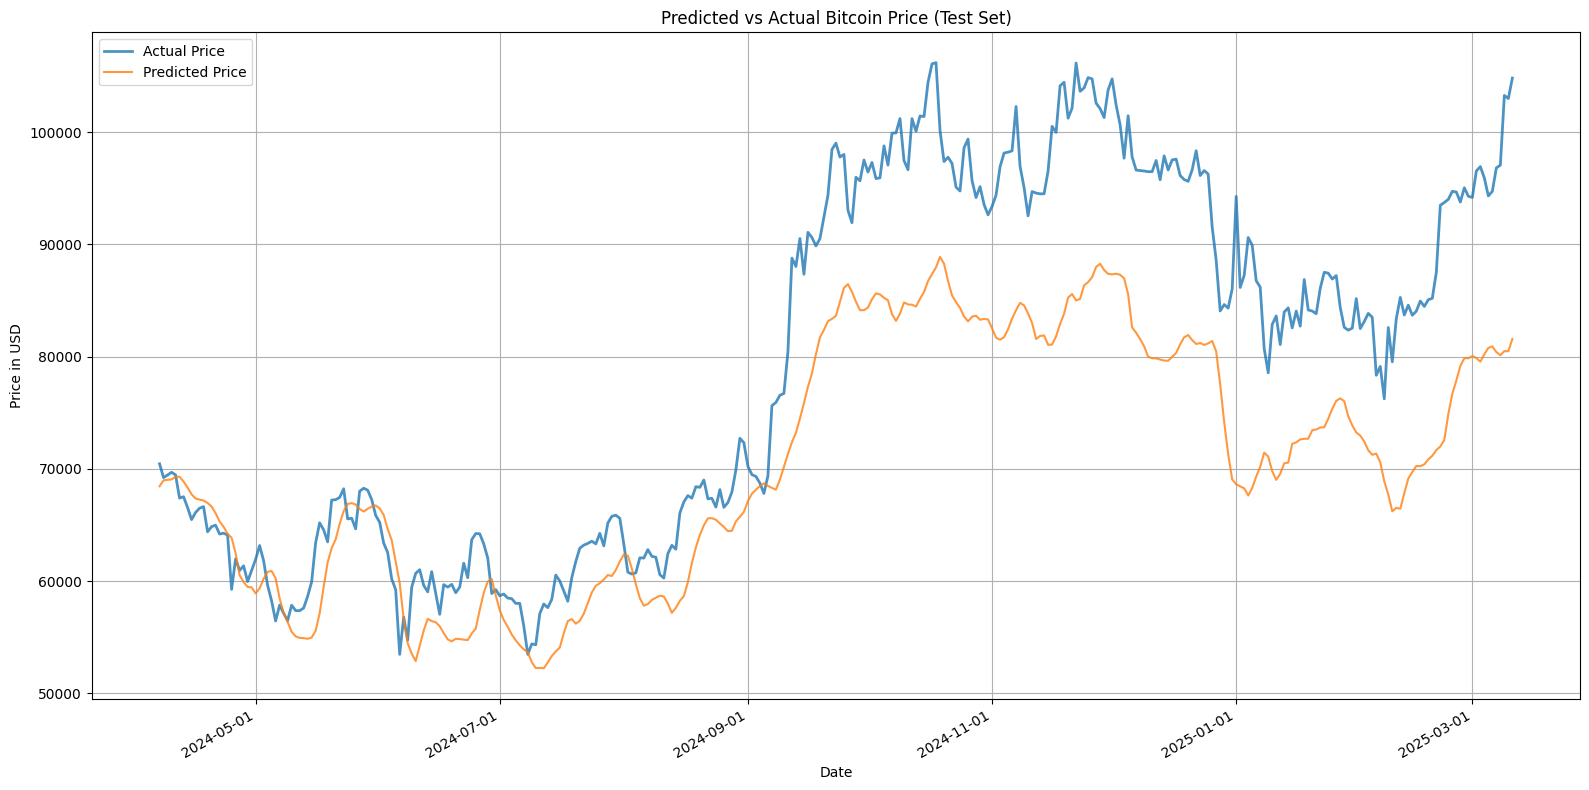

In [33]:
# Get test dates
test_dates = df['Timestamp'][training_size+val_size+sequence_length:training_size+val_size+len(y_test)+sequence_length]

# Create comparison plot
plt.figure(figsize=(16, 8))
plt.plot(test_dates, unscaled_y_test, label='Actual Price', linewidth=2, alpha=0.8)
plt.plot(test_dates, unscaled_test_predictions, label='Predicted Price', alpha=0.8)
plt.title('Predicted vs Actual Bitcoin Price (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)

# Format x-axis dates
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


In [34]:
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Price': unscaled_y_test.flatten(),
    'Predicted_Price': unscaled_predictions.flatten()
})

filename = f'lstm_baseline_results_rmse_{rmse:.2f}_mape_{mape_score:.2f}.csv'
results_df.to_csv(filename, index=False)
